In [4]:
from owlready2 import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
ontology_file = "test.owl"

In [6]:
try:
    # Load the ontology
    onto = get_ontology(ontology_file).load()
    print(f"Successfully loaded ontology: {onto.base_iri}")
    
    # Create the default world for SPARQL queries
    graph = onto.world.as_rdflib_graph()
    
except Exception as e:
    print(f"Error loading ontology: {e}")


Successfully loaded ontology: http://example.com/manufacturing_ontology.owl#


In [7]:
query = """
PREFIX onto: <http://example.com/manufacturing_ontology.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?reasonDesc ?downtime
WHERE {
  VALUES ?reasonDesc {
    "Unknown" "Ending order" "Filler" "CasePacker" "Cartoner"
  }
  ?event rdf:type onto:EventRecord .
  ?event onto:aeModelCategory "Unplanned" .
  ?event onto:eventHasReason ?reason .
  ?reason onto:reasonDescription ?reasonDesc .
  ?event onto:downtimeMinutes ?downtime .
}
"""

In [8]:
# Execute the query
results = list(graph.query_owlready(query))
print(f"Found {len(results)} results")

Found 1238 results


In [9]:
# Convert results to DataFrame for easier analysis
df = pd.DataFrame(results, columns=['ReasonDesc', 'Downtime'])
print(df.head())

  ReasonDesc  Downtime
0    Unknown  0.000000
1    Unknown  1.133334
2    Unknown  0.000000
3    Unknown  1.400000
4    Unknown  0.000000


/Users/MikeFitzgerald/venvs/pymmm_0_6_0/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 88.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/MikeFitzgerald/venvs/pymmm_0_6_0/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 89.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


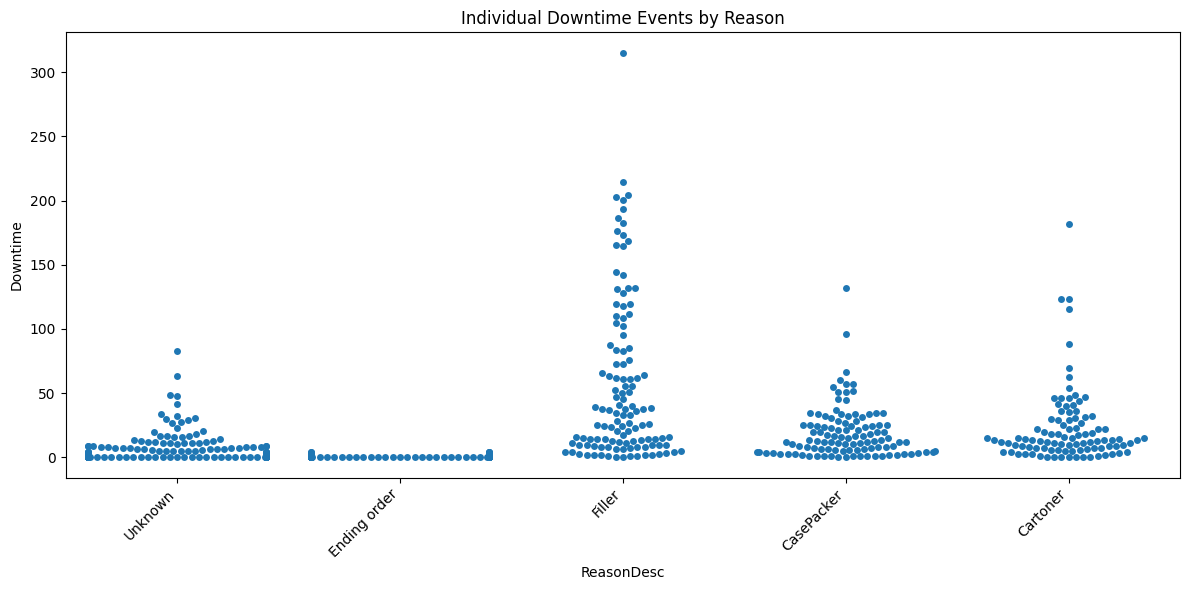

In [11]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='ReasonDesc', y='Downtime', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Individual Downtime Events by Reason')
plt.tight_layout()
plt.show()

In [13]:
line_query = """
PREFIX onto: <http://example.com/manufacturing_ontology.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?lineId ?downtime
WHERE {
  # Find events with "Unknown" reason
  ?event rdf:type onto:EventRecord .
  ?event onto:aeModelCategory "Unplanned" .
  ?event onto:eventHasReason ?reason .
  ?reason onto:reasonDescription "Filler" .

  # Find the resource involved
  ?event onto:involvesResource ?resource .

  # *** Ensure the resource is a ProductionLine ***
  ?resource rdf:type onto:ProductionLine .

  # Get the lineId and downtime
  ?resource onto:lineId ?lineId .
  ?event onto:downtimeMinutes ?downtime .
}
ORDER BY ?lineId
"""


In [14]:
line_query_results = list(graph.query_owlready(line_query))
print(f"Found {len(line_query_results)} results")

line_df = pd.DataFrame(line_query_results, columns=['lineId', 'downtime'])
print(line_df.head())




Found 118 results
     lineId   downtime
0  FIPCO001   6.933333
1  FIPCO001  40.516668
2  FIPCO001  26.083333
3  FIPCO001  14.133332
4  FIPCO001  23.833333


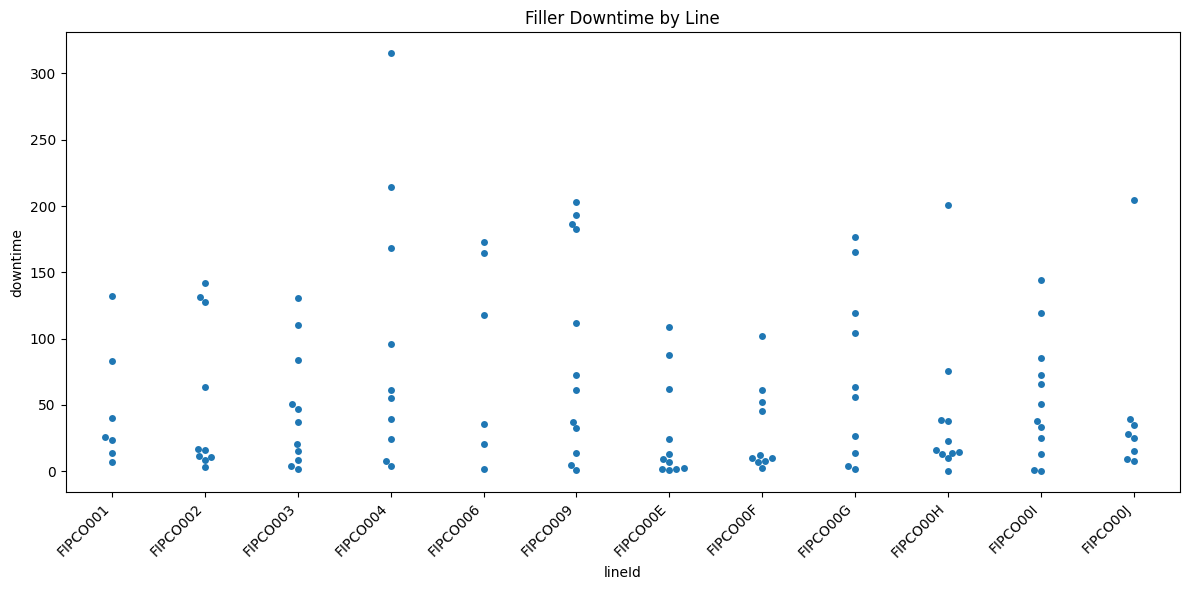

In [15]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='lineId', y='downtime', data=line_df)
plt.xticks(rotation=45, ha='right')
plt.title('Filler Downtime by Line')
plt.tight_layout()
plt.show()

In [16]:
by_equipment_query = """
PREFIX onto: <http://example.com/manufacturing_ontology.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?lineId ?equipId ?downtime
WHERE {
  # Find events with "Unknown" reason
  ?event rdf:type onto:EventRecord .
  ?event onto:aeModelCategory "Unplanned" .
  ?event onto:eventHasReason ?reason .
  ?reason onto:reasonDescription "Filler" .

  # Find the resource involved
  ?event onto:involvesResource ?resource .

  # *** Ensure the resource is an Equipment ***
  ?resource rdf:type onto:Equipment .

  # Get the equipmentId, its associated lineId, and the event downtime
  ?resource onto:equipmentId ?equipId .
  ?resource onto:associatedLineId ?lineId . # Property linking equipment to line
  ?event onto:downtimeMinutes ?downtime .
}
ORDER BY ?lineId ?equipId
"""

by_equipment_results = list(graph.query_owlready(by_equipment_query))
print(f"Found {len(by_equipment_results)} results")

by_equipment_df = pd.DataFrame(by_equipment_results, columns=['lineId', 'equipId', 'downtime'])
print(by_equipment_df.head())

Found 0 results
Empty DataFrame
Columns: [lineId, equipId, downtime]
Index: []


In [18]:
diagnostic_query1 = """
PREFIX onto: <http://example.com/manufacturing_ontology.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT (COUNT(?event) AS ?eventCountInvolvingEquipment)
WHERE {
  ?event rdf:type onto:EventRecord .
  ?event onto:involvesResource ?resource .
  # Check the type of the linked resource
  ?resource rdf:type onto:Equipment .
}
"""
print(list(graph.query_owlready(diagnostic_query1)))

[[4549]]


In [19]:
diagnostic_query2 = """
PREFIX onto: <http://example.com/manufacturing_ontology.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT (COUNT(?equip) AS ?equipmentWithLineIdCount)
WHERE {
  ?equip rdf:type onto:Equipment .
  # Check if the property exists for the equipment
  ?equip onto:associatedLineId ?lineId .
}
"""
print(list(graph.query_owlready(diagnostic_query2)))


[[61]]


In [22]:
diagnostic_query3 = """
# Diagnostic Query 3 (Should return 0 results based on findings)
PREFIX onto: <http://example.com/manufacturing_ontology.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?equipId (COUNT(*) AS ?eventCount)
WHERE {
  ?event rdf:type onto:EventRecord .
  ?event onto:aeModelCategory "Unplanned" .
  ?event onto:eventHasReason ?reason .
  ?reason onto:reasonDescription "Unknown" .
  ?event onto:involvesResource ?resource .
  ?resource rdf:type onto:Equipment .
  ?resource onto:equipmentId ?equipId .
  ?event onto:downtimeMinutes ?downtime .
}
GROUP BY ?equipId
LIMIT 10
"""
print(list(graph.query_owlready(diagnostic_query3)))






[['226.0', 5], ['229.0', 4], ['227.0', 5], ['151.0', 12], ['150.0', 12], ['152.0', 12], ['153.0', 11], ['149.0', 11], ['192.0', 10], ['193.0', 8]]


In [23]:
diagnostic_query4 = """
PREFIX onto: <http://example.com/manufacturing_ontology.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?lineId (COUNT(?event) AS ?fillerEventCount)
WHERE {
  ?event rdf:type onto:EventRecord .
  ?event onto:aeModelCategory "Unplanned" . # Unplanned event
  ?event onto:eventHasReason ?reason .
  ?reason onto:reasonDescription "Filler" . # Reason is Filler

  ?event onto:involvesResource ?resource .
  ?resource rdf:type onto:ProductionLine .  # Resource is ProductionLine

  ?resource onto:lineId ?lineId .
}
GROUP BY ?lineId
ORDER BY ?lineId
"""
print(list(graph.query_owlready(diagnostic_query4)))

[['FIPCO001', 7], ['FIPCO002', 10], ['FIPCO003', 11], ['FIPCO004', 10], ['FIPCO006', 6], ['FIPCO009', 12], ['FIPCO00E', 11], ['FIPCO00F', 10], ['FIPCO00G', 10], ['FIPCO00H', 11], ['FIPCO00I', 12], ['FIPCO00J', 8]]
